In [3]:
import os
import sys
import torch
import numpy as np
import shutil
import json

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.set_default_dtype(torch.float64)

In [6]:
def load_weights(model, fpath, device='cuda'):
    print("Path for Loading weights  '{}'".format(fpath))
    weights = torch.load(fpath,map_location = device)
    modelDict = model.state_dict()
    wgtsDict = weights['state_dict']
    print(modelDict.keys())
    print(wgtsDict.keys())
    newDict = dict()
    newDict['linear1.weight'] = wgtsDict['layers.0.weight']
    newDict['linear1.bias'] = wgtsDict['layers.0.bias']
    newDict['linear2.weight'] = wgtsDict['layers.1.weight']
    newDict['linear3.weight'] = wgtsDict['layers.2.weight']
    newWgts = dict()
    newWgts['state_dict'] = newDict
    model.eval()
    model.load_state_dict(newWgts['state_dict'])
    return model

In [7]:
# MODEL CREATION
import torch
import torch.nn as nn
from torch.autograd import Function

class ModifiedReluFunc(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.set_materialize_grads(False)
        ctx.x = x
        ctx.alpha = alpha
        return torch.relu(x)

    @staticmethod
    def backward(ctx, grad_output):
        if grad_output is None:
            return None, None
        return grad_output * ctx.x.mul(ctx.alpha).sigmoid(), None


class ModifiedRelu(nn.Module):
    def __init__(self, alpha):
        super(ModifiedRelu, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return ModifiedReluFunc.apply(x, self.alpha) 


## Creating a Binary MLP Model for MNIST Dataset
## Created model of 1000,1000 hidden layers

class BinaryMLPModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.activation = ModifiedRelu(149.86555429083975)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_dim, 1000)
        self.linear2 = nn.Linear(1000,1000,  bias = False)
        self.linear3 = nn.Linear(1000, output_dim  ,  bias = False)

     
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
      
        return x

In [8]:
def create_model():
    model = BinaryMLPModel(
        input_dim=28*28, output_dim=1,
    )
    
    model = model.to(device)
    return model

In [9]:
import torch
import torchvision

loss_values = []
epoch_values = []

def range_loss(x):
    rangeLoss = 0
    rangeLoss += torch.pow(torch.where(x - 1 > 0, x - 1, torch.zeros_like(x)), 2).sum()
    rangeLoss += torch.pow(torch.where(-1 - x > 0, -1 - x, torch.zeros_like(x)), 2).sum()
    return rangeLoss

def lambdaa_loss(l):
    lambdaaLoss = 0
    lambdaaLoss += 5 * torch.pow(torch.where(-l + 0.01 > 0, -l + 0.01, torch.zeros_like(l)), 2).sum()
    return lambdaaLoss    
    
def weight_loss(x, lambdaa, labels, model):
    
    model_output = model(x).squeeze()
    lambdaa = lambdaa.squeeze()
    
    lambdaa = lambdaa.to(device)
    model_output = model_output.to(device)
 
    secondPartOp = model_output * lambdaa * labels
    
    grad = torch.autograd.grad(
        outputs=secondPartOp,
        inputs=model.parameters(),
        grad_outputs=torch.ones_like(secondPartOp, requires_grad=False, device=secondPartOp.device).div(1000),
        create_graph=True,
        retain_graph=True,
    )
    
    weightLoss = 0

    for i, (p, grad) in enumerate(zip(model.parameters(), grad)):
        
        l = (p.detach().data - grad).pow(2).sum()
        
        weightLoss += l
        
    return weightLoss

def data_init(recons_data):
    c = 1 # Number of channels
    h = 28 # Dimension 1
    w = 28 # Dimension 2
    
    x = torch.randn(recons_data, c, h, w) * 1e-9
    lambdaa = torch.rand(recons_data, 1) * -10
    
    x = x.to(device)
    lambdaa = lambdaa.to(device)
    
    x.requires_grad_(True)
    lambdaa.requires_grad_(True)
    
    labels = torch.zeros(recons_data).type(torch.get_default_dtype())
    labels = labels.to(device)
    
    labels[:labels.shape[0] // 2] = -1
    labels[labels.shape[0] // 2:] = 1
    labels = labels.long()
    
    return lambdaa, x , labels


def optimizers(lambdaa,x):
    x_optimizer = torch.optim.SGD([x], lr=1e-5, momentum=0.9)
    l_optimizer = torch.optim.SGD([lambdaa], lr=1e-4, momentum=0.9)
#     x_optimizer = torch.optim.Adam([x], lr=1e-5)
#     l_optimizer = torch.optim.Adam([lambdaa], lr=1e-4)
    return x_optimizer,l_optimizer
    
    
def reconstruction(model):
    recons_data = 1000 # 500 for each class

    lambdaa , x , labels = data_init(recons_data)
    
    input_opt , lambdaa_opt = optimizers(lambdaa,x)

    num_of_epochs = 10001
    
    for epoch in range(num_of_epochs):

        weightLoss = weight_loss(x, lambdaa, labels, model)
        
        lambdaaLoss = lambdaa_loss(lambdaa)
        
        rangeLoss = range_loss(x)
        
        loss = lambdaaLoss + rangeLoss + weightLoss
            
        input_opt.zero_grad()
        lambdaa_opt.zero_grad()
        
        loss.backward()
        
        input_opt.step()
        lambdaa_opt.step()
        
        if(epoch < 1000):
            if(epoch%100 == 0):
                print("At Epoch ",epoch)
                print("Loss is ",loss)
                loss_values.append(loss)
                epoch_values.append(epoch)
                
        elif epoch%1000==0:
            print("At Epoch ",epoch)
            print("Loss is ",loss)
            torch.save(x, os.path.join(os.getcwd(), f'{epoch}_x1.pth'))
            loss_values.append(loss)
            epoch_values.append(epoch)
        
    return loss_values,epoch_values

In [10]:
model = create_model()
model.eval()
model = load_weights(model,"../input/pretrained-mnist/weights-mnist.pth", device=device)
loss_values, epoch_values = reconstruction(model)

Path for Loading weights  '../input/pretrained-mnist/weights-mnist.pth'
odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear3.weight'])
odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.1.weight', 'layers.2.weight'])
At Epoch  0
Loss is  tensor(167152.4174, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  100
Loss is  tensor(23038.0798, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  200
Loss is  tensor(2794.7208, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  300
Loss is  tensor(635.0206, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  400
Loss is  tensor(404.6258, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  500
Loss is  tensor(380.0474, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  600
Loss is  tensor(377.4251, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  700
Loss is  tensor(377.1442, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  800
Loss is  tensor(377.1105, device='cuda:0', grad_fn=<AddBackward0>)
At Epoch  900
Loss is  te

In [11]:
losses = []
for loss in loss_values:
    losses.append(int(loss.data))

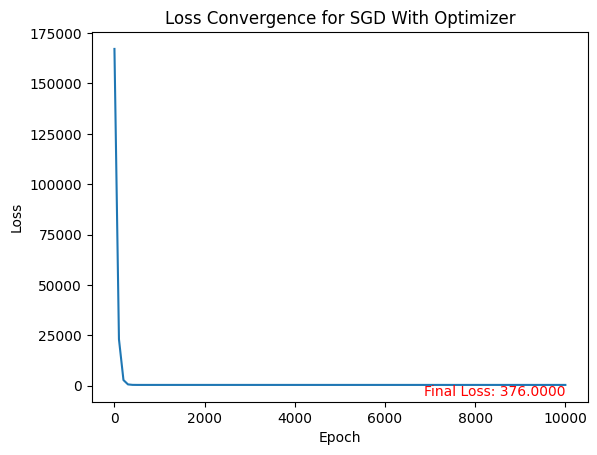

In [12]:
import matplotlib.pyplot as plt
plt.plot(epoch_values, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for SGD With Optimizer')

last_loss = losses[-1]
plt.text(epoch_values[-1], last_loss, f'Final Loss: {last_loss:.4f}', ha='right', va='top' , color='red')


plt.show()

In [13]:
import matplotlib.pyplot as plt
X = torch.load("./10000_x1.pth",map_location = device)

(1000, 28, 28, 1)


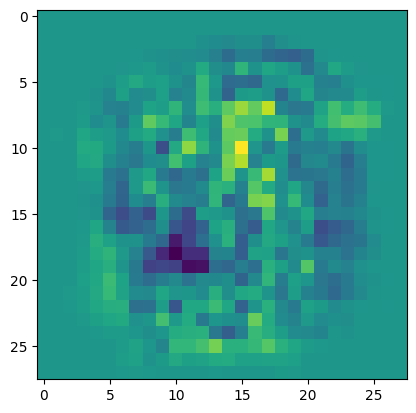

In [16]:
# X = X.cpu()
# X = X.detach().numpy()
print(X.shape)
X = X.reshape(1000,28,28,1)
plt.imshow(X[1])

In [18]:
import torch
import torchvision.datasets
import torchvision.transforms


def load_bound_dataset(dataset, batch_size, shuffle=False, start=None, end=None, **kwargs):
    def _bound_dataset(dataset, start, end):
        if start is None:
            start = 0
        if end is None:
            end = len(dataset)
        return torch.utils.data.Subset(dataset, range(start, end))

    dataset = _bound_dataset(dataset, start, end)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=shuffle, **kwargs)

def load_mnist(root, batch_size, train=False, transform=None, target_transform=None, **kwargs):
    print("loading mnist dataset")
    transform = transform if transform is not None else torchvision.transforms.ToTensor()
    dataset = torchvision.datasets.MNIST("./", train=train, transform=transform, target_transform=target_transform, download=True)
    return load_bound_dataset(dataset, batch_size, **kwargs)

def get_balanced_data(data_loader, data_amount):
    print('Fetching balanced dataset')
    # get balanced data
    data_amount_per_class = data_amount // 2

    labels_counter = {1: 0, 0: 0}
    labels_dict = {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1}
    x0, y0 = [], []
    got_enough = False
    for bx, by in data_loader:
        by = torch.stack([torch.tensor(labels_dict[int(cur_y)]) for cur_y in by])
        for i in range(len(bx)):
            if labels_counter[int(by[i])] < data_amount_per_class:
                labels_counter[int(by[i])] += 1
                x0.append(bx[i])
                y0.append(by[i])
            if (labels_counter[0] >= data_amount_per_class) and (labels_counter[1] >= data_amount_per_class):
                got_enough = True
                break
        if got_enough:
            break
    x0, y0 = torch.stack(x0), torch.stack(y0)
    return x0, y0

def get_dataloader():
    data_loader = load_mnist(root="./", batch_size=100, train=True, shuffle=False, start=0, end=50000)
    x0, y0 = get_balanced_data(data_loader, 500)
    x0 = x0.to(device)
    y0 = y0.to(device)
    return [(x0, y0)]
    

train_loader = get_dataloader()

loading mnist dataset
Fetching balanced dataset


In [19]:
import matplotlib.pyplot as plt
X = torch.load("./10000_x1.pth",map_location = device)
Xtrn, Ytrn = next(iter(train_loader))
ds_mean = Xtrn.mean(dim=0, keepdims=True).data

In [20]:
X = X  + ds_mean
X = X.cpu()
X = X.detach().numpy()
print(X.shape)
X = X.reshape(1000,28,28,1)

(1000, 1, 28, 28)


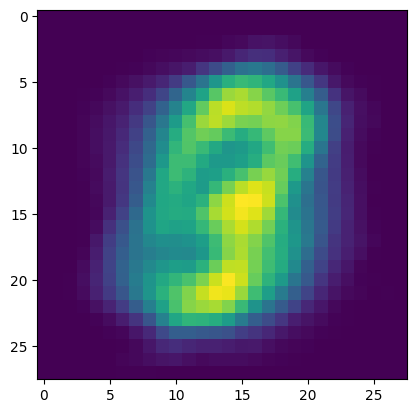

In [21]:
plt.imshow(X[100])